Código para la creación de imagen tiff con metadatos de drone

In [5]:
from PIL import Image
from PIL.TiffTags import TAGS
import re
import rasterio
import numpy as np
import math
import matplotlib.pyplot as plt

In [6]:
# obtenemos la imagen .tif
imagen = "./data/fotos/DJI_0051.TIF"
img = Image.open(imagen)
# obtenemos los Tags de la metadata y se almacenan en un diccionario
meta_dict = {TAGS[key]: img.tag[key] for key in img.tag_v2}
# Se imprime el diccionario para obtener la composición de los datos
# for rec in meta_dict:
#     print(rec, ":", meta_dict[rec])


In [7]:
# Extraemos el indicador xmp
p = meta_dict.get("XMP")
s = p.decode("UTF-8")
# dividimos por el salto de linea y obtenemos una lista
div = s.split("\n")

In [8]:
#eliminamos los espacios vacios 

for ind,recorrido in enumerate(div):
    div[ind]=recorrido.strip() 

div[17]

'drone-dji:AbsoluteAltitude="+84.65"'

In [9]:
usar = div[17]

result = re.search(":(.*)=", div[17])
result.group(1)

result2 = re.search("\"(.*)\"", div[17])
result2.group(1)

print(result.group(1))
print(result2.group(1))


AbsoluteAltitude
+84.65


Creo un diccionario donde almaceno las variables de la metadata con su valor

In [10]:
metadiccionario = {}
for ind,recorrido in enumerate(div):
    try:
        metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
    except:
        pass

print(metadiccionario)

{'xmpmeta xmlns:x': 'adobe:ns:meta/', 'RDF xmlns:rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#', 'Description rdf:about': 'DJI Meta Data', 'tiff': 'http://ns.adobe.com/tiff/1.0/', 'exif': 'http://ns.adobe.com/exif/1.0/', 'xmp': 'http://ns.adobe.com/xap/1.0/', 'xmpMM': 'http://ns.adobe.com/xap/1.0/mm/', 'dc': 'http://purl.org/dc/elements/1.1/', 'crs': 'http://ns.adobe.com/camera-raw-settings/1.0/', 'drone-dji': 'http://www.dji.com/drone-dji/1.0/', 'Camera': 'http://pix4d.com/camera/1.0', 'ModifyDate': '2022-02-11', 'CreateDate': '2022-02-11', 'Make': 'DJI', 'Model': 'FC6360', 'format': 'image/TIF', 'AbsoluteAltitude': '+84.65', 'RelativeAltitude': '+70.03', 'GpsLatitude': '11.22617803', 'GpsLongitude': '-74.18549349', 'GimbalRollDegree': '+0.00', 'GimbalYawDegree': '-96.50', 'GimbalPitchDegree': '-89.90', 'FlightRollDegree': '+6.40', 'FlightYawDegree': '-95.30', 'FlightPitchDegree': '+6.50', 'FlightXSpeed': '+0.10', 'FlightYSpeed': '+0.40', 'FlightZSpeed': '+0.00', 'CamReverse': '0

In [11]:
centro_x = float(metadiccionario["CalibratedOpticalCenterX"])
centro_y = float(metadiccionario["CalibratedOpticalCenterY"])
altura_vuelo = float(metadiccionario["RelativeAltitude"])
distancia_focal = float(metadiccionario["CalibratedFocalLength"])
angulo_giro = float(metadiccionario["GimbalYawDegree"])
latitud = float(metadiccionario["GpsLatitude"])
longitud = float(metadiccionario["GpsLongitude"])


Se calcula la resolución en metros por pixel.
Es decir, a cuantos metros equivale un pixel

In [12]:
resolucion = altura_vuelo/distancia_focal
resolucion

0.03660104451823564

In [13]:
# Abrir la imagen
with rasterio.open(imagen) as src:
    # Obtener la información de la imagen
    width = src.width
    height = src.height
    transform = src.transform
    crs = src.crs
    print(src.res)
    print("width:", width)


(1.0, 1.0)
width: 1600


c:\Users\Migue Polo\Documents\Codigos\kriging\venv\lib\site-packages\rasterio\__init__.py:332: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Cálculo de las coordenadas de las esquinas la imagen

Se divide entre 111111 para convertir los metros en grados. Esto se debe a que 1 grado de longitud o latitud en el ecuador es aproximadamente 111.111 km de ancho. Dado que la longitud y la latitud son medidas en grados, se debe convertir el tamaño de los píxeles en metros a grados para poder calcular las coordenadas extremas en grados.
Donde el ancho de la imagen en metros se divide entre la distancia en metros por grado para obtener la diferencia en grados. El factor 111111 es una aproximación, ya que la distancia en metros por grado varía según la latitud. Sin embargo, esta aproximación es suficiente para una precisión razonable.

Es importante tener en cuenta que esta conversión solo es válida para latitudes cercanas al ecuador, ya que la distancia en metros por grado varía según la latitud.

In [14]:
# Calcular las coordenadas de los extremos en metros
min_lon = float(metadiccionario["GpsLongitude"]) - (
    float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
max_lon = float(metadiccionario["GpsLongitude"]) + (
    float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
min_lat = float(metadiccionario["GpsLatitude"]) - (
    float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111
max_lat = float(metadiccionario["GpsLatitude"]) + (
    float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111
print(min_lon, max_lon, min_lat, max_lat)


-74.18575701778406 -74.18522996221594 11.225963913675452 11.226392146324548


In [15]:
transform = rasterio.transform.from_bounds(
    min_lon, min_lat, max_lon, max_lat, img.width, img.height)
transform


Affine(3.2940973007100636e-07, 0.0, -74.18575701778406,
       0.0, -3.2940973007373926e-07, 11.226392146324548)

Leo la imagen con rasterio y luego la guardo con las coordenadas correspondientes y como archivo tiff

In [16]:
# Abrir el archivo original
with rasterio.open(imagen) as src:
    # Leer los datos de la imagen
    image = src.read()

    # Crear una copia del archivo
    with rasterio.open(
        'data/drone51.TIF',
        'w',
        driver='GTiff',
        height=src.height,
        width=src.width,
        count=1,
        dtype="float64",
        crs={"init": "epsg:4326"},
        transform=transform,
    ) as dst:
        dst.write(image)


CPLE_AppDefinedError: Deleting data/drone51.TIF failed: Permission denied

*Aquí empiezo a probar la rotación de la imagen*

In [21]:
imagen_salida = "data/drone51.TIF"

In [24]:
from osgeo import gdal  # For read and manipulate rasters
from affine import Affine  # For easly manipulation of affine matrix


# Some functions declaration for clarify the code


def raster_center(raster):
    """This function return the pixel coordinates of the raster center 
    """

    # We get the size (in pixels) of the raster
    # using gdal
    width, height = raster.RasterXSize, raster.RasterYSize

    # We calculate the middle of raster
    xmed = width / 2
    ymed = height / 2

    return (xmed, ymed)


def rotate_gt(affine_matrix, angle, pivot=None):
    """This function generate a rotated affine matrix
    """

    # The gdal affine matrix format is not the same
    # of the Affine format, so we use a bullit-in function
    # to change it
    # see : https://github.com/sgillies/affine/blob/master/affine/__init__.py#L178
    affine_src = Affine.from_gdal(*affine_matrix)
    # We made the rotation. For this we calculate a rotation matrix,
    # with the rotation method and we combine it with the original affine matrix
    # Be carful, the star operator (*) is surcharged by Affine package. He make
    # a matrix multiplication, not a basic multiplication
    affine_dst = affine_src * affine_src.rotation(angle, pivot)
    # We retrun the rotated matrix in gdal format
    return affine_dst.to_gdal()


# Import the raster to rotate
# Here I use a sample of GDAL, dowloaded here : https://download.osgeo.org/geotiff/samples/spot/chicago/SP27GTIF.TIF
# and transformed in nc with qgis
# NB: the transformation in nc is specific for the original question,
# this step is not neccecary if you copy/past this code
dataset_src = gdal.Open("SP27GTIF.tiff")

# For no overwriting the original raster I make a copy

# I Get the reading/writing driver (GTIFF)
driver = gdal.GetDriverByName("GTiff")
# A new raster, the destination file, is created.
# This raster is a copy of the source raster (same size, values...)
datase_dst = driver.CreateCopy("SP27GTIF_rotate2.TIF", dataset_src, strict=0)

# Now we can rotate the raster

# First step, we get the affine tranformation matrix of the initial fine
# More info here : https://gdal.org/tutorials/geotransforms_tut.html#geotransforms-tut
gt_affine = dataset_src.GetGeoTransform()

# Second we get the center of the raster to set the rotation center
# Be carefull, the center is in pixel number, not in projected coordinates
# More info on the  "raster_center" comment's
center = raster_center(dataset_src)

# Third we rotate the destination raster, datase_dst, with setting a new
# affine matrix made by the "rotate_gt" function.
# gt_affine is the initial affine matrix
# -33 is an exemple angle (in degrees)
# and center the center of raster
datase_dst.SetGeoTransform(rotate_gt(gt_affine, -33, center))


0

In [20]:
from osgeo import gdal

path = 'data/drone51.TIF'
angle = angulo_giro
center_x = centro_x
center_y = centro_y

# Open raster
ds = gdal.Open(path, gdal.GA_Update)

# Get the raster geotransform
gt = ds.GetGeoTransform()

# Get the raster size
rows = ds.RasterYSize
cols = ds.RasterXSize

# Create the output raster
output_path = "path/to/rotated_raster.tif"
driver = ds.GetDriver()
output_ds = driver.Create(output_path, cols, rows, 1, gdal.GDT_Byte)

# Set the output raster geotransform
output_ds.SetGeoTransform(gt)

# Rotate the raster
gdal.Translate(output_path, ds, format='GTiff', outputSRS='EPSG:4326', rotation=angle, outputBounds=[center_x,center_y,0,0])

# Close the rasters
ds = None
output_ds = None

AttributeError: 'NoneType' object has no attribute 'SetGeoTransform'

In [19]:
from osgeo import gdal

# Abrir el archivo raster
raster = gdal.Open('data/drone51.TIF')

# Obtener las dimensiones del raster
cols = raster.RasterXSize
rows = raster.RasterYSize

# Crear una matriz de transformación de afinidad
transform = raster.GetGeoTransform()

# Calcular las coordenadas del centro del raster
center_x = transform[0] + cols/2*transform[1] + rows/2*transform[2]
center_y = transform[3] + cols/2*transform[4] + rows/2*transform[5]

# Crear una nueva matriz de transformación con una rotación de 91 grados
rotation = gdal.TermProgress_nocb
new_transform = gdal.GetGeoTransform(transform, rotation, center_x, center_y, angulo_giro)

# Crear una nueva imagen utilizando la matriz de transformación rotada
output = gdal.GetDriverByName("GTiff").Create("rotated_rasterMIGUE.tif", cols, rows, 1, gdal.GDT_Float32)
output.SetGeoTransform(new_transform)

# Copiar los datos del raster original a la nueva imagen
gdal.ReprojectImage(raster, output, raster.GetProjection(), output.GetProjection(), gdal.GRA_NearestNeighbour)

# Cerrar las imágenes
raster = None
output = None

AttributeError: module 'osgeo.gdal' has no attribute 'GetGeoTransform'

In [18]:
from osgeo import gdal

# Abrir archivo raster original
ds = gdal.Open('data/drone51.TIF')

# Crear una copia del archivo raster original
ds_rotate = gdal.GetDriverByName('GTiff').CreateCopy('output2.tif', ds)

# Establecer el ángulo de rotación en 91 grados
angle = angulo_giro

# Rotar el raster
ds_rotate.SetGeoTransform(ds.GetGeoTransform())
ds_rotate.SetProjection(ds.GetProjection())
ds_rotate.SetMetadata(ds.GetMetadata())
ds_rotate.GetRasterBand(1).Rotate(angle)

# Cerrar archivos raster
ds = None
ds_rotate = None

AttributeError: 'Band' object has no attribute 'Rotate'

In [59]:
import rasterio
from rasterio.warp import rotate

ImportError: cannot import name 'rotate' from 'rasterio.warp' (c:\Users\Migue Polo\Documents\Codigos\kriging\venv\lib\site-packages\rasterio\warp.py)

In [56]:
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [58]:
# Abrir el archivo raster original
with rasterio.open('data/drone51.TIF') as src:
    # Obtener los datos del raster como un array de numpy
    data = src.read(1)

    # Calcular la transformación para rotar el raster
    transform = src.transform * rasterio.Affine.rotation(angulo_giro, src.crs.transform_point(longitud, latitud)[
                                                         0], src.crs.transform_point(longitud, latitud)[1])
    # Crear un nuevo archivo raster con los datos rotados
    with rasterio.open('rotated.tif', 'w', driver='GTiff', height=src.height, width=src.width, count=1, dtype=data.dtype, crs=src.crs, transform=transform) as dst:
        # Escribir los datos rotados en el nuevo archivo
        dst.write(data, 1)


AttributeError: 'rasterio.crs.CRS' object has no attribute 'transform_point'

In [37]:
from affine import Affine

In [54]:
transform * Affine.translation(1.0, 1.0) * Affine.rotation(45.0)

# Affine(3.2940973007100636e-07, 0.0, -74.18575701778406,
#        0.0, -3.2940973007373926e-07, 11.226392146324548)


Affine(0.7071067811865476, -0.7071067811865476, 1.0,
       0.7071067811865476, 0.7071067811865476, 1.0)

In [13]:
# Determino las coordenadas de las esquinas
esquina_si = (min_lon, max_lat)
esquina_sd = (max_lon, max_lat)
esquina_ii = (min_lon, min_lat)
esquina_id = (max_lon, min_lat)

In [22]:
# Creo un rectángulo con las esquinas
# Esquinas del rectángulo
rectangle = [esquina_si,
             esquina_sd,
             esquina_ii,
             esquina_id]

# Centro del rectángulo
center = (float(metadiccionario["GpsLongitude"]),
          float(metadiccionario["GpsLatitude"]))

# Ángulo de rotación en radianes
theta = math.radians(float(metadiccionario["GimbalYawDegree"]))

# Rotación de las esquinas del rectángulo
rotated_rectangle = []
for x, y in rectangle:
    x_ = x - center[0]
    y_ = y - center[1]
    new_x = x_ * math.cos(theta) - y_ * math.sin(theta) + center[0]
    new_y = x_ * math.sin(theta) + y_ * math.cos(theta) + center[1]
    rotated_rectangle.append((new_x, new_y))

print(rotated_rectangle)
# En rotated_rectangle se encuentran las esquinas del rectángulo rotado
# en 0 está la esquina superior izquierda
# en 1 está la esquina superior derecha
# en 2 está la esquina inferior izquierda
# en 3 está la esquina inferior derecha

[(-74.18525091785402, 11.226415625133368), (-74.18531058223816, 11.225891957554513), (-74.18567639776184, 11.226464102445487), (-74.18573606214598, 11.225940434866631)]


In [23]:
# Encuentro los valores máximos y mínimos de las coordenadas
x_var = []
y_var = []

for i in rotated_rectangle:
    x_var.append(i[0])
    y_var.append(i[1])

xmin_rotated = min(x_var)
xmax_rotated = max(x_var)
ymin_rotated = min(y_var)
ymax_rotated = max(y_var)
print(xmin_rotated, xmax_rotated, ymin_rotated, ymax_rotated)

-74.18573606214598 -74.18525091785402 11.225891957554513 11.226464102445487


In [24]:
transform_rotated = rasterio.transform.from_bounds(
    xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated, img.width, img.height)
transform_rotated


Affine(3.0321518247333755e-07, 0.0, -74.18573606214598,
       0.0, -4.4011145459530955e-07, 11.226464102445487)

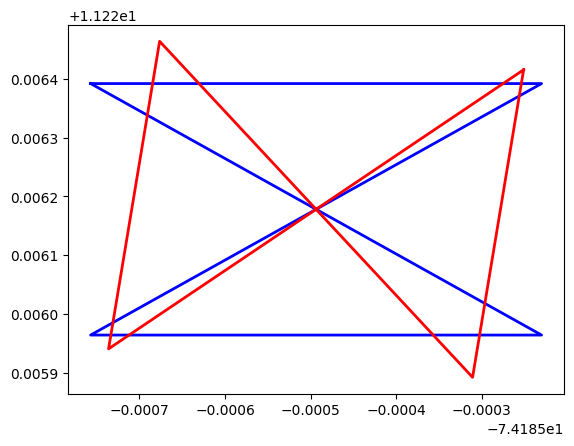

In [25]:
# Create figure and axes
fig, ax = plt.subplots()

# Plot the original rectangle
x = [c[0] for c in rectangle] + [rectangle[0][0]]
y = [c[1] for c in rectangle] + [rectangle[0][1]]
ax.plot(x, y, 'b-', linewidth=2)

# Plot the rotated rectangle
x = [c[0] for c in rotated_rectangle] + [rotated_rectangle[0][0]]
y = [c[1] for c in rotated_rectangle] + [rotated_rectangle[0][1]]
ax.plot(x, y, 'r-', linewidth=2)

# Show the plot
plt.show()

In [28]:
from matplotlib import pyplot

BoundingBox(left=100.0, bottom=70.0961894323342, right=348.20508075688775, top=300.0)


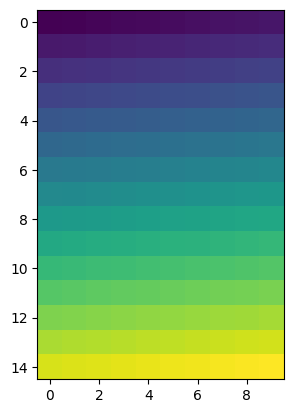

In [36]:
def test_rotated_bounds():
    with rasterio.open('data/rotated.tif') as src:
        print(src.bounds)
        pyplot.imshow(src.read(1))
        assert src.res == (20.0, 10.0)
        np.testing.assert_almost_equal(
            src.bounds,
            (100.0, 70.0961894323342, 348.20508075688775, 300.0))

test_rotated_bounds()

c:\Users\Migue Polo\Documents\Codigos\kriging\venv\lib\site-packages\rasterio\__init__.py:332: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


TypeError: Image data of dtype object cannot be converted to float

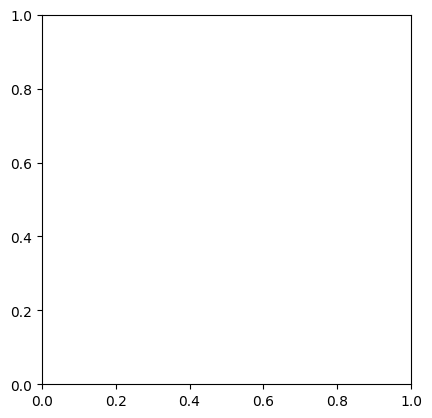

In [31]:
# Abrir el archivo original
with rasterio.open(imagen) as src:
    # Leer los datos de la imagen
    image = src.read()

    # Crear una copia del archivo
    with rasterio.open(
        'data/drone51ROTATEEEE1.TIF',
        'w',
        driver='GTiff',
        height=src.height,
        width=src.width,
        count=1,
        dtype="float64",
        crs={"init": "epsg:4326"},
        transform=transform_rotated,
    ) as dst:
        dst.write(image)
